#Load data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
secret_path="/content/drive/MyDrive/gold_prices.csv"

In [ ]:

spark = SparkSession.builder \
    .appName("Read Gold Prices CSV") \
    .getOrCreate()

schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Buy Price", DoubleType(), True),
    StructField("Sell Price", DoubleType(), True)
])

df = spark.read.option("header", True).schema(schema).csv(secret_path)



# Import libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, expr
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors, DenseMatrix
import random
from pyspark.mllib.linalg.distributed import RowMatrix, IndexedRow, IndexedRowMatrix
from math import sqrt
from pyspark.sql.types import StructType, StructField, DateType, DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Generate samples with features and labels as below



* Features: gold prices of 10 consecutive previous dates of the date t

* Label: the gold price of the date t.


In [ ]:
window = Window.orderBy("Date")

# --- Tạo df_buy ---
df_buy = df

# Tạo lag cho 10 ngày trước của Buy Price
for i in range(1, 11):
    df_buy = df_buy.withColumn(f"Buy_{i}", lag("Buy Price", i).over(window))

feature_cols_buy = [f"Buy_{i}" for i in range(10, 0, -1)]

# Cast sang DoubleType
for c in feature_cols_buy:
    df_buy = df_buy.withColumn(c, col(c).cast(DoubleType()))

# Lọc bỏ dòng có null trong các cột lag
df_buy = df_buy.where(~expr("exists(array(" + ",".join(feature_cols_buy) + "), x -> x is null)"))

# VectorAssembler cho features Buy
assembler_buy = VectorAssembler(inputCols=feature_cols_buy, outputCol="features")
df_buy = assembler_buy.transform(df_buy)

# Tạo label Buy Price
df_buy = df_buy.withColumn("label", col("Buy Price").cast(DoubleType()))

# Lấy cột cần thiết
df_buy = df_buy.select("Date", "features", "label")


# --- Tạo df_sell ---
df_sell = df

# Tạo lag cho 10 ngày trước của Sell Price
for i in range(1, 11):
    df_sell = df_sell.withColumn(f"Sell_{i}", lag("Sell Price", i).over(window))

feature_cols_sell = [f"Sell_{i}" for i in range(10, 0, -1)]

# Cast sang DoubleType
for c in feature_cols_sell:
    df_sell = df_sell.withColumn(c, col(c).cast(DoubleType()))

# Lọc bỏ dòng có null trong các cột lag
df_sell = df_sell.where(~expr("exists(array(" + ",".join(feature_cols_sell) + "), x -> x is null)"))

# VectorAssembler cho features Sell
assembler_sell = VectorAssembler(inputCols=feature_cols_sell, outputCol="features")
df_sell = assembler_sell.transform(df_sell)

# Tạo label Sell Price
df_sell = df_sell.withColumn("label", col("Sell Price").cast(DoubleType()))

# Lấy cột cần thiết
df_sell = df_sell.select("Date", "features", "label")

# Hiển thị kết quả
df_buy.show(truncate=False)
df_sell.show(truncate=False)


+----------+-------------------------------------------------------------+-----+
|Date      |features                                                     |label|
+----------+-------------------------------------------------------------+-----+
|2009-08-11|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-12|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-13|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-14|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-15|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-16|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-17|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-18|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-19|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-20|[21.13,21.13,21.

# Class CUR

In [ ]:
class CURReducer:
    def __init__(self, n_cols_reduced=5):
        self.n_cols_reduced = n_cols_reduced
        self.selected_col_indices = []
        self.selected_row_indices = []
        self.U_eff = None  # RDD of vectors (c × k)
        self.C = None

    def select_columns(self, X: RowMatrix):
        n_cols = X.numCols()
        col_sq = X.rows.flatMap(lambda v: [(i, v[i] ** 2) for i in range(n_cols)])
        col_sums = col_sq.reduceByKey(lambda a, b: a + b)
        total_sum = col_sums.map(lambda x: x[1]).reduce(lambda a, b: a + b)
        col_probs = col_sums.mapValues(lambda x: x / total_sum)
        sampled = col_probs.takeSample(False, self.n_cols_reduced, seed=42)
        self.selected_col_indices = [i for i, _ in sampled]

    def select_rows(self, X: RowMatrix):
        indexed = IndexedRowMatrix(X.rows.zipWithIndex().map(lambda x: IndexedRow(x[1], x[0])))
        row_norms = indexed.rows.map(lambda r: (r.index, float(r.vector.norm(2) ** 2)))
        total = row_norms.map(lambda x: x[1]).reduce(lambda a, b: a + b)
        row_probs = row_norms.mapValues(lambda x: x / total)
        sampled = row_probs.takeSample(False, self.n_cols_reduced, seed=42)
        self.selected_row_indices = [int(i) for i, _ in sampled]

    def filter_matrix_cols(self, X: RowMatrix, selected_cols):
        selected = sorted(selected_cols)
        bc_selected = X.rows.context.broadcast(selected)
        return RowMatrix(X.rows.map(lambda v: Vectors.dense([v[i] for i in bc_selected.value])))

    def filter_matrix_rows(self, M: RowMatrix, selected_rows):
        indexed = IndexedRowMatrix(M.rows.zipWithIndex().map(lambda x: IndexedRow(x[1], x[0])))
        bc_rows = M.rows.context.broadcast(set(selected_rows))
        filtered = indexed.rows.filter(lambda r: r.index in bc_rows.value).map(lambda r: r.vector)
        return RowMatrix(filtered)

    def compute_U_eff(self, W: RowMatrix):
        k = min(W.numCols(), W.numRows(), self.n_cols_reduced)
        svd = W.computeSVD(k, computeU=True)
        U = svd.U  # RowMatrix
        s_vals = svd.s.toArray()

        sigma_inv_sq_vals = []
        for i in range(k):
            for j in range(k):
                val = 1.0 / (s_vals[i] ** 2) if i == j and s_vals[i] > 1e-10 else 0.0
                sigma_inv_sq_vals.append(val)
        sigma_inv_sq = DenseMatrix(k, k, sigma_inv_sq_vals)

        sc = W.rows.context
        bc_sigma_inv_sq = sc.broadcast(sigma_inv_sq)

        U_rdd = U.rows

        def outer_product(u):
            u_arr = u.toArray()
            return DenseMatrix(k, k, [u_arr[i] * u_arr[j] for i in range(k) for j in range(k)])

        projector = U_rdd.map(outer_product).reduce(
            lambda a, b: DenseMatrix(k, k, [a[i, j] + b[i, j] for i in range(k) for j in range(k)])
        )

        # Multiply with Sigma⁻²
        final_matrix = DenseMatrix(k, k, [
            sum(projector[i, m] * bc_sigma_inv_sq.value[m, j] for m in range(k))
            for i in range(k) for j in range(k)
        ])

        self.U_eff = final_matrix  # DenseMatrix (k x k)

    def fit(self, X: RowMatrix):
        self.select_columns(X)
        self.select_rows(X)
        self.C = self.filter_matrix_cols(X, self.selected_col_indices)
        W = self.filter_matrix_rows(self.C, self.selected_row_indices)
        self.compute_U_eff(W)

    def transform(self, X: RowMatrix):
        C = self.filter_matrix_cols(X, self.selected_col_indices)
        projector = self.U_eff  # DenseMatrix k x k
        bc_proj = C.rows.context.broadcast(projector)

        def project_row(row):
            x = row.toArray()
            return Vectors.dense([
                sum(x[i] * bc_proj.value[i, j] for i in range(len(x)))
                for j in range(projector.numCols)
            ])

        projected_rows = C.rows.map(project_row)
        return RowMatrix(projected_rows)


#Buy Price

## Infer the new representation (row embedding) for each feature vector in the training and test sets.

In [ ]:
from pyspark.ml.linalg import DenseVector as MLDenseVector
from pyspark.mllib.linalg import Vectors as MLLIBVectors

def ml_to_mllib(v):
    # Chuyển Vector ML sang Vector MLLIB
    return MLLIBVectors.dense(v.toArray())

# Giả sử df có cột "features" kiểu pyspark.ml.linalg.Vector
features_rdd = df_buy.select("features").rdd.map(lambda row: ml_to_mllib(row["features"]))

# Tạo RowMatrix đúng chuẩn
mat = RowMatrix(features_rdd)


In [ ]:

cur = CURReducer(n_cols_reduced=5)
cur.fit(mat)
X_reduced = cur.transform(mat)



In [ ]:
X_reduced.rows.take(2)

[DenseVector([0.0003, 242.41, 1789.7287, 37279.6976, 90994.1187]),
 DenseVector([0.0003, 242.41, 1789.7287, 37279.6976, 90994.1187])]

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.mllib.linalg import Vectors
from pyspark.sql import Row

# 1. Thêm cột index cho df_buy để đánh thứ tự dòng
df_buy_indexed = df_buy.withColumn("idx", monotonically_increasing_id())

# 2. Lấy X_reduced (RowMatrix) sang RDD [(idx, vector_embedding)]
rdd_reduced = X_reduced.rows.zipWithIndex().map(lambda x: (x[1], x[0]))

# 3. Chuyển rdd_reduced thành DataFrame (idx, feature_reduced)
df_reduced = rdd_reduced.map(lambda x: Row(idx=x[0], feature_reduced=Vectors.dense(x[1].toArray()))).toDF()

# 4. Join df_buy_indexed với df_reduced theo idx
df_joined = df_buy_indexed.join(df_reduced, on="idx", how="inner")

# 5. Thay thế cột feature cũ bằng cột feature_reduced
df_final = df_joined.drop("features").withColumnRenamed("feature_reduced", "features").drop("idx")

# df_final là DataFrame mới với cột feature đã được thay bằng vector embedding 5 chiều


In [ ]:
df_final.show(truncate=False)

+----------+-----+------------------------------------------------------------------------------------------------+
|Date      |label|features                                                                                        |
+----------+-----+------------------------------------------------------------------------------------------------+
|2009-08-11|21.13|[3.0777693031276243E-4,242.4099785439147,1789.7286834462823,37279.69760364226,90994.11871588604]|
|2009-08-12|21.13|[3.0777693031276243E-4,242.4099785439147,1789.7286834462823,37279.69760364226,90994.11871588604]|
|2009-08-13|21.13|[3.0777693031276243E-4,242.4099785439147,1789.7286834462823,37279.69760364226,90994.11871588604]|
|2009-08-14|21.13|[3.0777693031276243E-4,242.4099785439147,1789.7286834462823,37279.69760364226,90994.11871588604]|
|2009-08-15|21.13|[3.0777693031276243E-4,242.4099785439147,1789.7286834462823,37279.69760364226,90994.11871588604]|
|2009-08-16|21.13|[3.0777693031276243E-4,242.4099785439147,1789.72868344

In [ ]:
from pyspark.ml.linalg import Vectors as mlVectors
from pyspark.mllib.linalg import Vectors as mllibVectors
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import VectorUDT

# UDF chuyển đổi mllib Vector sang ml Vector
convert_udf = udf(lambda v: mlVectors.dense(v.toArray()), VectorUDT())

# Áp dụng chuyển đổi lên cột features của train_data_buy_new
df_final = df_final.withColumn("features", convert_udf(col("features")))


## Training and evaluate a linear regression model as in Task 2 with the two new sets.


In [ ]:


# Split the data into training and testing datasets
train_data_buy, test_data_buy = df_buy.randomSplit([0.7, 0.3], seed=123)
train_data_buy_new, test_data_buy_new = df_final.randomSplit([0.7, 0.3], seed=123)



In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.8,
    tol=1e-6
)

# Train the model on the training data
lr_model_old_data = lr.fit(train_data_buy)
lr_model_new_data = lr.fit(train_data_buy_new)



In [ ]:


# Đánh giá trên train
train_summary = lr_model_old_data.evaluate(train_data_buy)
train_rmse = train_summary.rootMeanSquaredError
train_r2 = train_summary.r2

# Đánh giá trên test
train_summary_new = lr_model_new_data.evaluate(train_data_buy_new)
train_rmse_new = train_summary_new.rootMeanSquaredError
train_r2_new = train_summary_new.r2


print(f"RMSE (Old Data): {train_rmse}")
print(f"RMSE (New Data): {train_rmse_new}")


RMSE (Old Data): 0.43458662239639423
RMSE (New Data): 0.5015043147136635


In [ ]:


# Đánh giá trên train
test_summary = lr_model_old_data.evaluate(test_data_buy)
test_rmse = test_summary.rootMeanSquaredError
test_r2 = test_summary.r2

# Đánh giá trên test
test_summary_new = lr_model_new_data.evaluate(test_data_buy_new)
test_rmse_new = test_summary_new.rootMeanSquaredError
test_r2_new = test_summary_new.r2


print(f"RMSE (Old Data): {test_rmse}")
print(f"RMSE (New Data): {test_rmse_new}")


RMSE (Old Data): 0.4118046115231098
RMSE (New Data): 0.48073308500008466


## Draw a bar chart to contrast losses between the new and original sets.

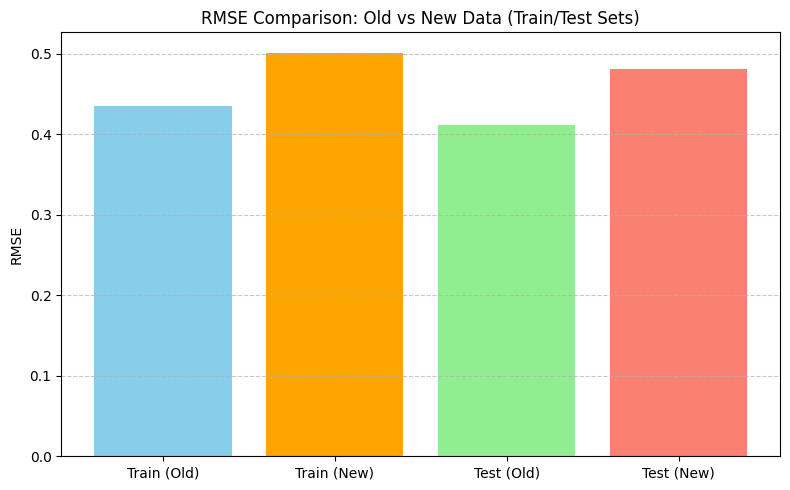

In [ ]:
import matplotlib.pyplot as plt

# RMSE values for training and testing
rmse_values = {
    "Train (Old)":  train_rmse,
    "Train (New)":  train_rmse_new,
    "Test (Old)":   test_rmse,
    "Test (New)":   test_rmse_new
}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(rmse_values.keys(), rmse_values.values(), color=["skyblue", "orange", "lightgreen", "salmon"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Old vs New Data (Train/Test Sets)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Sell Price

## Infer the new representation (row embedding) for each feature vector in the training and test sets.

In [ ]:
from pyspark.ml.linalg import DenseVector as MLDenseVector
from pyspark.mllib.linalg import Vectors as MLLIBVectors

def ml_to_mllib(v):
    # Chuyển Vector ML sang Vector MLLIB
    return MLLIBVectors.dense(v.toArray())

# Giả sử df có cột "features" kiểu pyspark.ml.linalg.Vector
features_rdd = df_sell.select("features").rdd.map(lambda row: ml_to_mllib(row["features"]))

# Tạo RowMatrix đúng chuẩn
mat = RowMatrix(features_rdd)


In [ ]:

cur = CURReducer(n_cols_reduced=5)
cur.fit(mat)
X_reduced = cur.transform(mat)



In [ ]:
X_reduced.rows.take(2)


[DenseVector([0.0003, 126.4772, 1280.6324, 23697.5714, 93086.3597]),
 DenseVector([0.0003, 126.4772, 1280.6324, 23697.5714, 93086.3597])]

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.mllib.linalg import Vectors
from pyspark.sql import Row

# 1. Thêm cột index cho df_buy để đánh thứ tự dòng
df_sell_indexed = df_sell.withColumn("idx", monotonically_increasing_id())

# 2. Lấy X_reduced (RowMatrix) sang RDD [(idx, vector_embedding)]
rdd_reduced = X_reduced.rows.zipWithIndex().map(lambda x: (x[1], x[0]))

# 3. Chuyển rdd_reduced thành DataFrame (idx, feature_reduced)
df_reduced = rdd_reduced.map(lambda x: Row(idx=x[0], feature_reduced=Vectors.dense(x[1].toArray()))).toDF()

# 4. Join df_buy_indexed với df_reduced theo idx
df_joined = df_sell_indexed.join(df_reduced, on="idx", how="inner")

# 5. Thay thế cột feature cũ bằng cột feature_reduced
df_final = df_joined.drop("features").withColumnRenamed("feature_reduced", "features").drop("idx")

# df_final là DataFrame mới với cột feature đã được thay bằng vector embedding 5 chiều


In [ ]:
from pyspark.ml.linalg import Vectors as mlVectors
from pyspark.mllib.linalg import Vectors as mllibVectors
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import VectorUDT

# UDF chuyển đổi mllib Vector sang ml Vector
convert_udf = udf(lambda v: mlVectors.dense(v.toArray()), VectorUDT())

# Áp dụng chuyển đổi lên cột features của train_data_buy_new
df_final = df_final.withColumn("features", convert_udf(col("features")))


In [ ]:
df_final.show(truncate=False)

+----------+-----+-------------------------------------------------------------------------------------------------+
|Date      |label|features                                                                                         |
+----------+-----+-------------------------------------------------------------------------------------------------+
|2009-08-11|21.19|[2.9862522294439093E-4,126.47716412855833,1280.6323885476422,23697.57139858727,93086.35967722732]|
|2009-08-12|21.19|[2.9862522294439093E-4,126.47716412855833,1280.6323885476422,23697.57139858727,93086.35967722732]|
|2009-08-13|21.19|[2.9862522294439093E-4,126.47716412855833,1280.6323885476422,23697.57139858727,93086.35967722732]|
|2009-08-14|21.19|[2.9862522294439093E-4,126.47716412855833,1280.6323885476422,23697.57139858727,93086.35967722732]|
|2009-08-15|21.19|[2.9862522294439093E-4,126.47716412855833,1280.6323885476422,23697.57139858727,93086.35967722732]|
|2009-08-16|21.19|[2.9862522294439093E-4,126.47716412855833,1280

## Training and evaluate a linear regression model as in Task 2 with the two new sets.


In [ ]:


# Split the data into training and testing datasets
train_data_sell, test_data_sell = df_sell.randomSplit([0.7, 0.3], seed=123)
train_data_sell_new, test_data_sell_new = df_final.randomSplit([0.7, 0.3], seed=123)



In [ ]:
# Initialize the Linear Regression model
lr = LinearRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.8,
    tol=1e-6
)

# Train the model on the training data
lr_model_old_data = lr.fit(train_data_sell)
lr_model_new_data = lr.fit(train_data_sell_new)



In [ ]:


# Đánh giá trên train
train_summary = lr_model_old_data.evaluate(train_data_sell)
train_rmse = train_summary.rootMeanSquaredError
train_r2 = train_summary.r2

# Đánh giá trên test
train_summary_new = lr_model_new_data.evaluate(train_data_sell_new)
train_rmse_new = train_summary_new.rootMeanSquaredError
train_r2_new = train_summary_new.r2


print(f"RMSE (Old Data): {train_rmse}")
print(f"RMSE (New Data): {train_rmse_new}")


RMSE (Old Data): 0.4409777414429002
RMSE (New Data): 0.48921925358750323


In [ ]:


# Đánh giá trên train
test_summary = lr_model_old_data.evaluate(test_data_sell)
test_rmse = test_summary.rootMeanSquaredError
test_r2 = test_summary.r2

# Đánh giá trên test
test_summary_new = lr_model_new_data.evaluate(test_data_sell_new)
test_rmse_new = test_summary_new.rootMeanSquaredError
test_r2_new = test_summary_new.r2


print(f"RMSE (Old Data): {test_rmse}")
print(f"RMSE (New Data): {test_rmse_new}")


RMSE (Old Data): 0.4309925486753766
RMSE (New Data): 0.4836213385021448


## Draw a bar chart to contrast losses between the new and original sets.

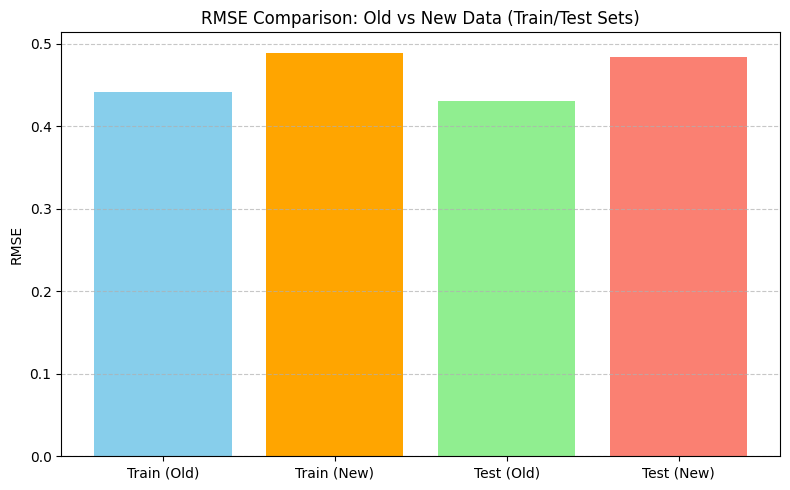

In [ ]:
import matplotlib.pyplot as plt

# RMSE values for training and testing
rmse_values = {
    "Train (Old)":  train_rmse,
    "Train (New)":  train_rmse_new,
    "Test (Old)":   test_rmse,
    "Test (New)":   test_rmse_new
}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(rmse_values.keys(), rmse_values.values(), color=["skyblue", "orange", "lightgreen", "salmon"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Old vs New Data (Train/Test Sets)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
